In [77]:
import pandas as pd

In [60]:
input_df=pd.read_csv('train.csv')

#### check data distribution

In [62]:
label_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
counts=[]
for i in label_list:
    counts.append((i, input_df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['label', 'number_of_comments'])
df_stats

,label,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


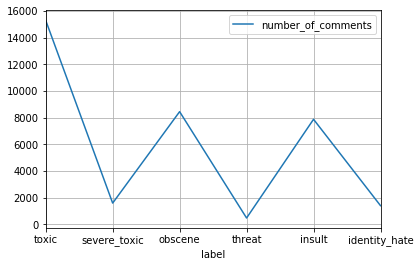

In [63]:
df_stats.plot(x='label', y='number_of_comments', kind='line', grid=True)

#### clean the comments

In [88]:
import re
def clean_comment(df):
    comment=df['comment_text']
    comment = comment.lower()
    comment = re.sub(r"what's", "what is ", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have ", comment)
    comment = re.sub(r"can't", "can not ", comment)
    comment = re.sub(r"n't", " not ", comment)
    comment = re.sub(r"i'm", "i am ", comment)
    comment = re.sub(r"\'re", " are ", comment)
    comment = re.sub(r"\'d", " would ", comment)
    comment = re.sub(r"\'ll", " will ", comment)
    comment = re.sub(r"\'scuse", " excuse ", comment)
    comment = re.sub('\W', ' ', comment)
    comment = re.sub('\s+', ' ', comment)
    comment = re.sub(r":|!|#|@|%|_|(|)|[|]|\'|\"", "", comment)
    comment = comment.strip()
    return comment

input_df['cleaned_Comment']=input_df.apply(clean_comment,axis=1)

In [89]:
input_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_Comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can not make any real suggestions on im...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


#### check no of words distribution among several comments

In [90]:
def measure_n_words(df):
    return len(df['cleaned_Comment'].split())

comment_lens=input_df.apply(measure_n_words,axis=1)

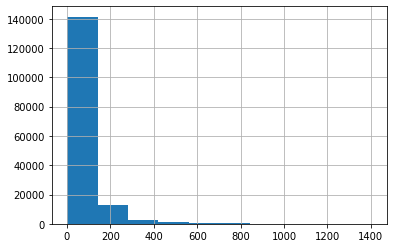

In [91]:
comment_lens.hist(bins=10)

In [92]:
comment_lens.describe()

count    159571.000000
mean         68.769457
std         101.663856
min           1.000000
25%          17.000000
50%          37.000000
75%          77.000000
max        1403.000000
dtype: float64

#### Prepare train and validation set

In [116]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(input_df, random_state=0, test_size=0.25, shuffle=True)
trainX=pd.DataFrame(columns=['cleaned_Comment'])
trainX['cleaned_Comment']=train['cleaned_Comment']
trainY=train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

testX=pd.DataFrame(columns=['cleaned_Comment'])
testX['cleaned_Comment']=test['cleaned_Comment']

testY=test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

#### check train and validation data distrubution

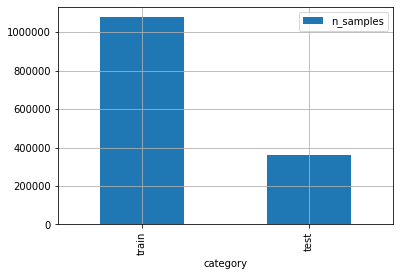

In [101]:
split_stats=pd.DataFrame(columns=['category','n_samples'])
split_stats['category']=['train','test']
split_stats['n_samples']=[train.size,test.size]
split_stats.plot(x='category', y='n_samples', kind='bar', grid=True)

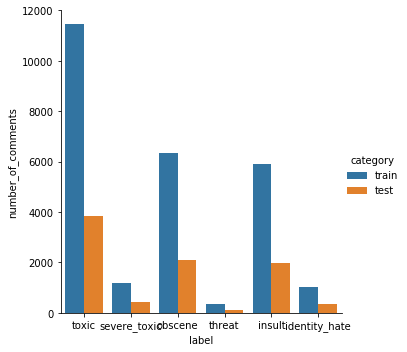

In [112]:
label_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
counts=[]
for i in label_list:
    counts.append((i, train[i].sum()))
df_stats_train = pd.DataFrame(counts, columns=['label', 'number_of_comments'])
#df_stats_train.plot(x='label',y='number_of_comments',kind='bar',grid=True)

label_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
counts=[]
for i in label_list:
    counts.append((i, test[i].sum()))
df_stats_test = pd.DataFrame(counts, columns=['label', 'number_of_comments'])
#df_stats_test.plot(x='label',y='number_of_comments',kind='bar',grid=True)

import seaborn as sns
df4 = pd.concat([df_stats_train, df_stats_test], axis=0)
df4['category'] = (len(df_stats_train)*('train',) + len(df_stats_test)*('test',))
sns.factorplot(x='label', y='number_of_comments', hue='category', kind='bar', data=df4)

#### tokenize comments and generate sequences

In [131]:
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(trainX['cleaned_Comment'])
vocab_size = len(t.word_index) + 1

trainX['cleaned_Comment_seq'] = t.texts_to_sequences(trainX['cleaned_Comment'])
testX['cleaned_Comment_seq'] = t.texts_to_sequences(testX['cleaned_Comment'])

#### pad the sequences

In [133]:
from keras.preprocessing.sequence import pad_sequences
max_length = 100
train_padded_input = pad_sequences(trainX['cleaned_Comment_seq'], maxlen=max_length, padding='post',truncating='post')
test_padded_input = pad_sequences(testX['cleaned_Comment_seq'], maxlen=max_length, padding='post',truncating='post')

#### load fasttext model for pretrained embeddings

In [136]:
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format('cc.en.300.bin')

print(model.most_similar('teacher'))
# Output = [('headteacher', 0.8075869083404541), ('schoolteacher', 0.7955552339553833), ('teachers', 0.733420729637146), ('teaches', 0.6839243173599243), ('meacher', 0.6825737357139587), ('teach', 0.6285147070884705), ('taught', 0.6244685649871826), ('teaching', 0.6199781894683838), ('schoolmaster', 0.6037642955780029), ('lessons', 0.5812176465988159)]

print(model.similarity('teacher', 'teaches'))

[('teachers', 0.754426121711731), ('teacher.The', 0.7518178224563599), ('teacher-', 0.7434277534484863), ('teacher.But', 0.7367769479751587), ('teacher.He', 0.7327343225479126), ('teacher.She', 0.7304024696350098), ('educator', 0.7279404997825623), ('teacher.This', 0.7241753935813904), ('teacher.A', 0.7125754356384277), ('teacher.So', 0.7104303240776062)]
0.39747047


#### Create Embedding Matrix

In [144]:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 300))
n_words_error=0
for word, i in t.word_index.items():
    try:
        embedding_vector = model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        #print('Word: {} not having any ngrams which are present in Fast Text vocab'.format(word))
        n_words_error+=1
        pass
print('We could not get vector for {} no of words'.format(n_words_error))

We could not get vector for 6399 no of words


#### Define Model Architecture and learn

In [152]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding, Dropout

k_model=Sequential()
k_model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
k_model.add(LSTM(300, return_sequences=False))
k_model.add(Dense(300,activation='relu'))
k_model.add(Dense(206,activation='relu'))
k_model.add(Dropout(0.2))
k_model.add(Dense(6,activation='sigmoid'))

In [154]:
from keras import metrics
k_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.categorical_accuracy])

In [187]:
import numpy
k_model.fit(train_padded_input,numpy.array(trainY.values),batch_size=32,epochs=3,use_multiprocessing=True,
            validation_data=(test_padded_input,numpy.array(testY.values)),verbose=True)

Train on 119678 samples, validate on 39893 samples
Epoch 1/3
119678/119678 [==============================] - 565s 5ms/step - loss: 0.0852 - categorical_accuracy: 0.9874 - val_loss: 0.0543 - val_categorical_accuracy: 0.9936
Epoch 2/3
119678/119678 [==============================] - 566s 5ms/step - loss: 0.0520 - categorical_accuracy: 0.9943 - val_loss: 0.0499 - val_categorical_accuracy: 0.9936
Epoch 3/3
119678/119678 [==============================] - 570s 5ms/step - loss: 0.0483 - categorical_accuracy: 0.9928 - val_loss: 0.0515 - val_categorical_accuracy: 0.9936


In [189]:
k_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          47955000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 206)               62006     
_________________________________________________________________
dropout_2 (Dropout)          (None, 206)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1242      
Total params: 48,829,748
Trainable params: 874,748
Non-trainable params: 47,955,000
____________________________________

In [193]:
k_model.save('Toxicity_Identifier_V1')

In [202]:
k_model.history.history

{'val_loss': [0.05427633029521348, 0.04994480763083324, 0.05154436956212835],
 'val_categorical_accuracy': [0.9935828340811671,
  0.9935828340811671,
  0.9935828340811671],
 'loss': [0.08523218938838817, 0.05202672893951105, 0.04831807221819666],
 'categorical_accuracy': [0.9874162335530802,
  0.9943264426210331,
  0.9928474740484093]}

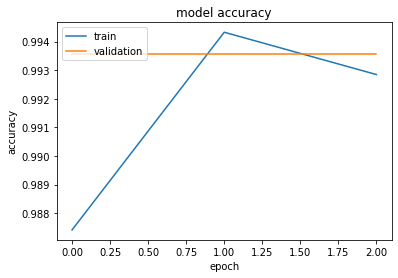

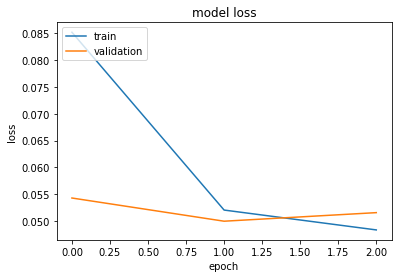

In [204]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(k_model.history.history['categorical_accuracy'])
plt.plot(k_model.history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(k_model.history.history['loss'])
plt.plot(k_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Evaluate Model on given test set

In [205]:
unseen_comments_df=pd.read_csv('test.csv')[]


In [214]:
unseen_comments_label_df=pd.read_csv('test_labels.csv')

In [207]:
unseen_comments_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [208]:
unseen_comments_label_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [210]:
unseen_comments_df['cleaned_unseen_comments']=unseen_comments_df.apply(clean_comment,axis=1)
unseen_comments_df['cleaned_unseen_comments_seq'] = t.texts_to_sequences(unseen_comments_df['cleaned_unseen_comments'])
unseen_comments_padded = pad_sequences(unseen_comments_df['cleaned_unseen_comments_seq'], maxlen=max_length, padding='post',truncating='post')

In [216]:
predictions=k_model.predict_proba(unseen_comments_padded,batch_size=32,verbose=1)

153164/153164 [==============================] - 186s 1ms/step


In [223]:
df = pd.DataFrame(predictions, columns = [toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])  

In [225]:
df.insert(0, 'id', unseen_comments_df['id'])

In [229]:
df.to_csv('output_on_unseen_comments.csv',header=True,index=False)

In [230]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)